# Experiments with CAMELS

In [1]:
%load_ext autoreload
%autoreload 2

# Path to the main CAMELS folder
CAMELS_DIR = "/home/mgauch/ealstm_regional_modeling/data/CAMELS/"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/mgauch/ealstm_regional_modeling"

In [2]:
# Imports
import json
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bokeh.sampledata import us_states

sys.path.append(BASE_CODE_DIR)
from main import Model
from papercode import datautils
from papercode.clusterutils import get_silhouette_scores, get_clusters, get_label_2_color, get_variance_reduction
from papercode.datasets import CamelsTXT
from papercode.datautils import load_attributes
from papercode.plotutils import get_shape_collections
from papercode.utils import get_basin_list

# get polygon points of only the CONUS states
us_states = us_states.data.copy()
del us_states["HI"]
del us_states["AK"]

In [3]:
# Convert file/folder path to pathlib Path objects
CAMELS_DIR = Path(CAMELS_DIR)
CODE_DIR = Path(BASE_CODE_DIR)

# Not really of importance, but need to be defined for the data set class.
VAL_START = pd.to_datetime('01101989', format='%d%m%Y')
VAL_END = pd.to_datetime('30091999', format='%d%m%Y')

In [4]:
basins = get_basin_list()

In [6]:
#datautils.add_camels_attributes(CAMELS_DIR)

In [7]:
attributes = load_attributes(db_path=CODE_DIR / 'data' / 'attributes.db',
                             basins=basins,
                             drop_lat_lon=False)

In [8]:
attributes.columns

Index(['gauge_lat', 'gauge_lon', 'elev_mean', 'slope_mean', 'area_gages2',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity',
       'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac',
       'clay_frac', 'carbonate_rocks_frac', 'geol_permeability', 'p_mean',
       'pet_mean', 'p_seasonality', 'frac_snow', 'aridity', 'high_prec_freq',
       'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest',
       'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff'],
      dtype='object')

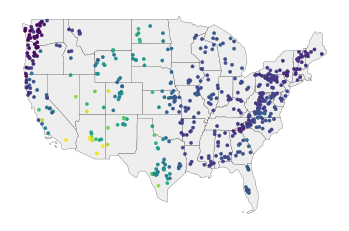

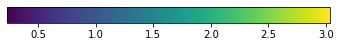

In [83]:
# draw the maps
attributes = load_attributes(db_path=CODE_DIR / "data" / "attributes.db",
                             basins=basins, drop_lat_lon=False)

data = attributes.copy()
data['color'] = data['aridity']
f, ax = plt.subplots(1)
collection = get_shape_collections(us_states)
ax.add_collection(collection)
mp = plt.scatter(x=data["gauge_lon"], y=data["gauge_lat"], s=10, linewidth=0.5, c=data['color'], cmap='viridis')
plt.axis(False)
f, ax = plt.subplots(1, figsize=(5,2))
plt.colorbar(mp, ax=ax, orientation='horizontal')
ax.remove()
plt.tight_layout()

In [17]:
forcings = {}
discharge = {}
for basin in basins:
    forcings[basin] = datautils.load_forcing(CAMELS_DIR, basin)
    discharge[basin] = datautils.load_discharge(CAMELS_DIR, basin, forcings[basin][1])

In [18]:
forcings['01022500'][0].head()

,Year,Mnth,Day,Hr,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
1980-01-01,1980,1,1,12,31185.94,0.0,229.98,0.0,-1.04,-11.11,250.13
1980-01-02,1980,1,2,12,31302.07,0.0,234.29,0.0,0.36,-10.45,256.83
1980-01-03,1980,1,3,12,31370.89,0.0,241.54,0.0,-0.02,-12.09,226.09
1980-01-04,1980,1,4,12,31449.60,0.0,228.29,0.0,-4.22,-14.84,179.91
1980-01-05,1980,1,5,12,31449.60,0.0,205.40,0.0,-7.48,-14.99,167.17


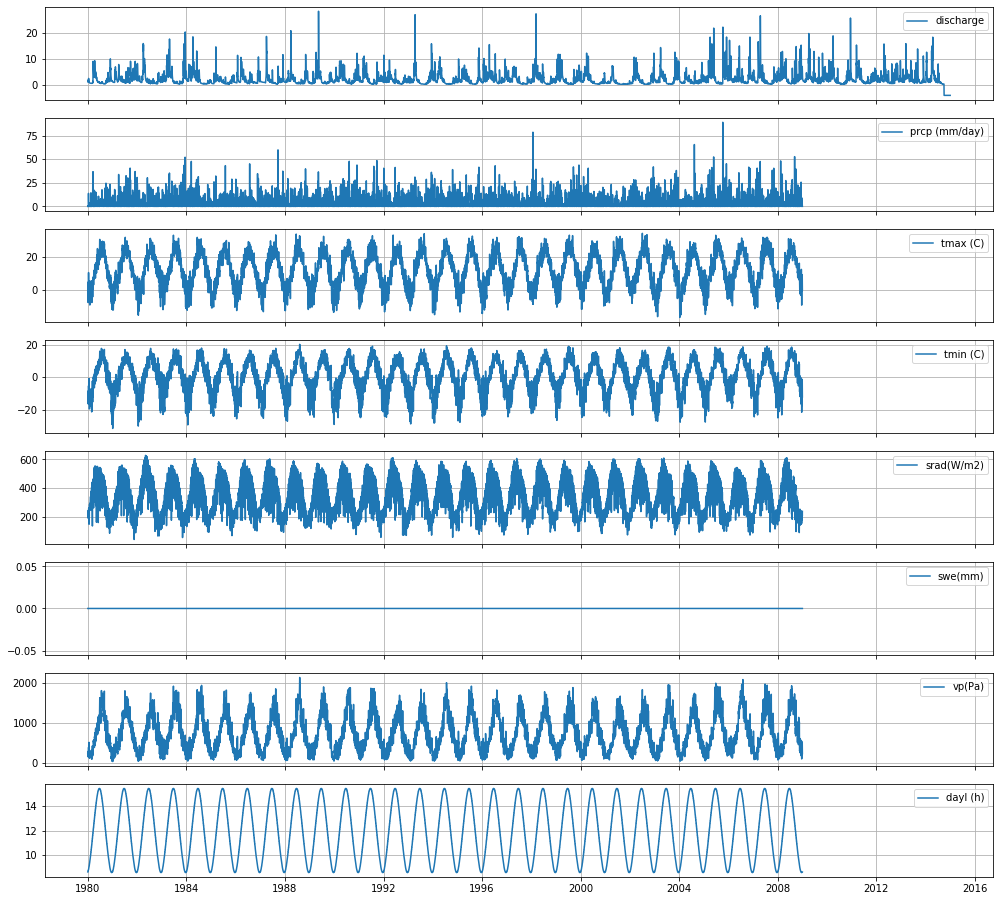

In [44]:
f, ax = plt.subplots(nrows=8, ncols=1, figsize=(17,8*2), sharex=True)
ax[0].plot(discharge['01022500'], label='discharge')
ax[1].plot(forcings['01022500'][0]['prcp(mm/day)'], label='prcp (mm/day)')
ax[2].plot(forcings['01022500'][0]['tmax(C)'], label='tmax (C)')
ax[3].plot(forcings['01022500'][0]['tmin(C)'], label='tmin (C)')
ax[4].plot(forcings['01022500'][0]['srad(W/m2)'], label='srad(W/m2)')
ax[5].plot(forcings['01022500'][0]['swe(mm)'], label='swe(mm)')
ax[6].plot(forcings['01022500'][0]['vp(Pa)'], label='vp(Pa)')
ax[7].plot(forcings['01022500'][0]['dayl(s)'] / (60 * 60), label='dayl (h)')
_ = [(a.grid(), a.legend()) for a in ax]